In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from sklearn.metrics import classification_report
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#reading dataset using github link
url='https://raw.githubusercontent.com/viditgupta-11/Ensemble-Learning/master/Information.csv'

df=pd.read_csv(url,encoding='latin-1')

In [3]:
#first 5 rows of dataset
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [4]:
#last 5 rows of dataset
df.tail()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
20045,815757572,True,golden,259,NaN,female,1.0000,yes,1.0,8/5/15 21:16,(rp),302,female,0084B4,capuletrosa,yes,https://pbs.twimg.com/profile_images/656793310...,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",NaN,783,10/26/15 13:20,6.587400e+17,Verona ªÁ,NaN
20046,815757681,True,golden,248,NaN,male,1.0000,yes,1.0,8/15/12 21:17,"Whatever you like, it's not a problem at all. ...",2513,male,CFB929,BenNight41,yes,https://pbs.twimg.com/profile_images/639815429...,0,0,Greg Hardy you a good player and all but don't...,NaN,13523,10/26/15 12:40,6.587300e+17,"Kansas City, MO",NaN
20047,815757830,True,golden,264,NaN,male,1.0000,yes,1.0,9/3/12 1:17,#TeamBarcelona ..You look lost so you should f...,50,male,0084B4,realuzzyfluxz,yes,https://pbs.twimg.com/profile_images/655473271...,0,C0DEED,You can miss people and still never want to se...,NaN,26419,10/26/15 13:20,6.587400e+17,Lagos Nigeria,NaN
20048,815757921,True,golden,250,NaN,female,0.8489,yes,1.0,11/6/12 23:46,Anti-statist; I homeschool my kids. Aspiring t...,70804,female,9266CC,argumatronic,yes,https://pbs.twimg.com/profile_images/657716093...,0,0,@bitemyapp i had noticed your tendency to pee ...,NaN,56073,10/26/15 12:40,6.587300e+17,Texas Hill Country,NaN
20049,815757985,True,golden,249,NaN,female,1.0000,yes,1.0,4/14/14 17:22,Teamwork makes the dream work.,3348,female,0084B4,MeganFitz20,yes,https://pbs.twimg.com/profile_images/655134724...,0,C0DEED,I think for my APUSH creative project I'm goin...,NaN,2922,10/26/15 13:19,6.587400e+17,NaN,NaN


In [5]:
#getting dataset size and various columns
print("Dataset Size:",df.size)
print("Columns are:",df.columns)

Dataset Size: 521300
Columns are: Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')


In [6]:
#short description of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

**Observation:**

1.   Most of the columns are complete.
2.   The required 'gender' column has a few null values.



**Removing rows other than Male and Females**

In [7]:
#removing rows with null values in 'gender'
df.dropna(subset=['gender'],inplace=True)

In [8]:
#resultant summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19953 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               19953 non-null  int64  
 1   _golden                19953 non-null  bool   
 2   _unit_state            19953 non-null  object 
 3   _trusted_judgments     19953 non-null  int64  
 4   _last_judgment_at      19903 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      19953 non-null  float64
 7   profile_yn             19953 non-null  object 
 8   profile_yn:confidence  19953 non-null  float64
 9   created                19953 non-null  object 
 10  description            16224 non-null  object 
 11  fav_number             19953 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             19953 non-null  object 
 14  name                   19953 non-null  object 
 15  pr

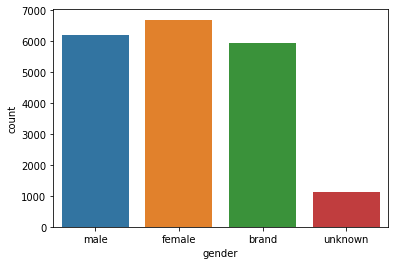

In [9]:
#plotting count of various gender values
sns.countplot(x='gender',data=df)

In [10]:
#removing 'brand' and 'unknown' category
df.drop(df[df['gender']=='brand'].index,inplace=True)
df.drop(df[df['gender']=='unknown'].index,inplace=True)

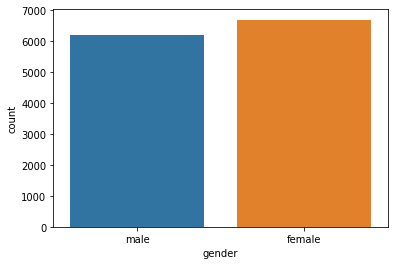

In [11]:
#verifying above step
sns.countplot(x='gender',data=df)

In [12]:
#resultant dataset rows and columns
df.shape

(12894, 26)

**Making a new columns combining text and description**

In [13]:
#combining description and text column
df['description_text']=df['description'].astype(str)+" "+df['text'].astype(str)

In [14]:
#verifying above step
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12894 entries, 0 to 20049
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               12894 non-null  int64  
 1   _golden                12894 non-null  bool   
 2   _unit_state            12894 non-null  object 
 3   _trusted_judgments     12894 non-null  int64  
 4   _last_judgment_at      12858 non-null  object 
 5   gender                 12894 non-null  object 
 6   gender:confidence      12894 non-null  float64
 7   profile_yn             12894 non-null  object 
 8   profile_yn:confidence  12894 non-null  float64
 9   created                12894 non-null  object 
 10  description            11194 non-null  object 
 11  fav_number             12894 non-null  int64  
 12  gender_gold            36 non-null     object 
 13  link_color             12894 non-null  object 
 14  name                   12894 non-null  object 
 15  pr

**Pre-Processing:**

"description_text" requires following adjustments.
1.   Removing Puntuations
2.   Tokenisation
3.   Stopwords removal


**Removing Punctuations**

In [15]:
#function to remove puntuations from each row
def rem_pun(t):
  t="".join([char for char in t if char not in string.punctuation])
  t=re.sub('[0-9]+','',t)
  return t

df['description_text_punct']=df['description_text'].apply(lambda x:rem_pun(x))
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,description_text,description_text_punct
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai,i sing my own rhythm. Robbie E Responds To Cri...,i sing my own rhythm Robbie E Responds To Crit...
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada),I'm the author of novels filled with family dr...,Im the author of novels filled with family dra...
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade,louis whining and squealing and all i absolute...,louis whining and squealing and all i absolute...
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada),"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Mobile guy ers Shazam Google Kleiner Perkins ...
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Ricky Wilson The Best FRONTMANKaiser Chiefs Th...


**Tokenization**

In [16]:
#tokenizing each row
def tokenize(t):
  t=re.split('\W+',t)
  return t

df['description_text_tok']=df['description_text_punct'].apply(lambda x:tokenize(x.lower()))
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,description_text,description_text_punct,description_text_tok
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai,i sing my own rhythm. Robbie E Responds To Cri...,i sing my own rhythm Robbie E Responds To Crit...,"[i, sing, my, own, rhythm, robbie, e, responds..."
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada),I'm the author of novels filled with family dr...,Im the author of novels filled with family dra...,"[im, the, author, of, novels, filled, with, fa..."
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade,louis whining and squealing and all i absolute...,louis whining and squealing and all i absolute...,"[louis, whining, and, squealing, and, all, i, ..."
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada),"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Mobile guy ers Shazam Google Kleiner Perkins ...,"[mobile, guy, ers, shazam, google, kleiner, pe..."
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Ricky Wilson The Best FRONTMANKaiser Chiefs Th...,"[ricky, wilson, the, best, frontmankaiser, chi..."


**Remove stopwords**

In [17]:
#downloading required package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
#defining stopwords in english
stopword=nltk.corpus.stopwords.words('english')

In [19]:
#rremoving stopwords
def rem_stop(t):
  t=[w for w in t if w not in stopword]
  return t

df['description_text_nostop']=df['description_text_tok'].apply(lambda x:rem_stop(x))
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,description_text,description_text_punct,description_text_tok,description_text_nostop
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai,i sing my own rhythm. Robbie E Responds To Cri...,i sing my own rhythm Robbie E Responds To Crit...,"[i, sing, my, own, rhythm, robbie, e, responds...","[sing, rhythm, robbie, e, responds, critics, w..."
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada),I'm the author of novels filled with family dr...,Im the author of novels filled with family dra...,"[im, the, author, of, novels, filled, with, fa...","[im, author, novels, filled, family, drama, ro..."
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade,louis whining and squealing and all i absolute...,louis whining and squealing and all i absolute...,"[louis, whining, and, squealing, and, all, i, ...","[louis, whining, squealing, absolutely, adore,..."
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada),"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Mobile guy ers Shazam Google Kleiner Perkins ...,"[mobile, guy, ers, shazam, google, kleiner, pe...","[mobile, guy, ers, shazam, google, kleiner, pe..."
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Ricky Wilson The Best FRONTMANKaiser Chiefs Th...,"[ricky, wilson, the, best, frontmankaiser, chi...","[ricky, wilson, best, frontmankaiser, chiefs, ..."


In [20]:
#converting column description_text_nostop from list to string
def listToStr(s):
  str1=""
  for e in s:
    str1+=e+" "
  return str1

df['description_text_nostop_str']=df['description_text_nostop'].apply(lambda x:listToStr(x))
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,description_text,description_text_punct,description_text_tok,description_text_nostop,description_text_nostop_str
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai,i sing my own rhythm. Robbie E Responds To Cri...,i sing my own rhythm Robbie E Responds To Crit...,"[i, sing, my, own, rhythm, robbie, e, responds...","[sing, rhythm, robbie, e, responds, critics, w...",sing rhythm robbie e responds critics win eddi...
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada),I'm the author of novels filled with family dr...,Im the author of novels filled with family dra...,"[im, the, author, of, novels, filled, with, fa...","[im, author, novels, filled, family, drama, ro...",im author novels filled family drama romance û...
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade,louis whining and squealing and all i absolute...,louis whining and squealing and all i absolute...,"[louis, whining, and, squealing, and, all, i, ...","[louis, whining, squealing, absolutely, adore,...",louis whining squealing absolutely adore louis...
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada),"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Mobile guy ers Shazam Google Kleiner Perkins ...,"[mobile, guy, ers, shazam, google, kleiner, pe...","[mobile, guy, ers, shazam, google, kleiner, pe...",mobile guy ers shazam google kleiner perkins y...
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Ricky Wilson The Best FRONTMANKaiser Chiefs Th...,"[ricky, wilson, the, best, frontmankaiser, chi...","[ricky, wilson, best, frontmankaiser, chiefs, ...",ricky wilson best frontmankaiser chiefs best b...


**Q1) What are the most common emotions/words used by Males and Females?**

(-0.5, 399.5, 199.5, -0.5)

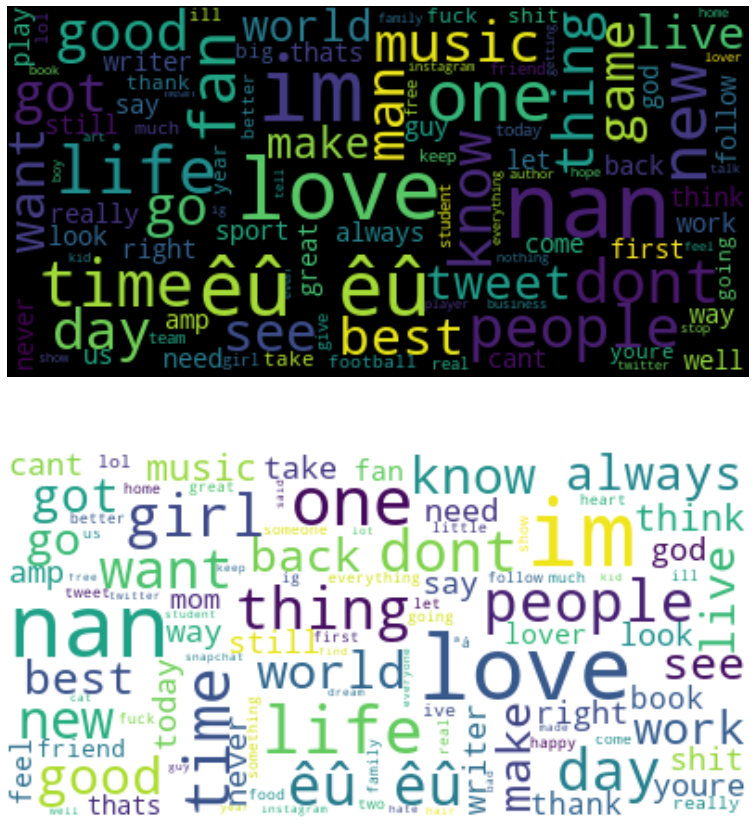

In [21]:
from wordcloud import WordCloud
df_male=df[df['gender']=='male']
df_female=df[df['gender']=='female'];
tweet_male=" ".join(i for i in df_male.description_text_nostop_str)
tweet_female=" ".join(i for i in df_female.description_text_nostop_str)
fig,ax=plt.subplots(2,1,figsize=(15,15))
wordcloud_male=WordCloud(max_font_size=50,max_words=100,background_color="black").generate(tweet_male)
wordcloud_female=WordCloud(max_font_size=50,max_words=100,background_color="white").generate(tweet_female)
ax[0].imshow(wordcloud_male,interpolation='bilinear')
ax[0].axis('off')
ax[1].imshow(wordcloud_female,interpolation='bilinear')
ax[1].axis('off')

**Ans.** From the wordclouds above,

1.   Both the males and females have used the words 'love' and 'time' a lot.
2.   Males have used words like 'people', 'one', 'music', 'fan', 'thing', etc.
3.   Females have used words like 'life', 'girl', 'world', 'thing', etc.



**Q2) Which gender makes more typos in their tweets?**

In [22]:
#installing required package
!apt install -qq enchant
!pip install pyenchant

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,310 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Preconfiguring packages ...
Selecting previously unselected package libtext-iconv-perl.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../0-libt

In [23]:
#using enchant library for extracting english-US dictionary
import enchant
d=enchant.Dict("en_US")

In [24]:
#getting names dataset to ignore names used in the tweets as mistake
!pip install names-dataset

     |████████████████████████████████| 1.4MB 2.8MB/s 


In [25]:
from names_dataset import NameDataset
m=NameDataset()

In [26]:
#making a list of almost all the apostrophe words to ignore them
apos=['doesnt','cant','wont','dont','Ive','Id','Im','Ill','shes','hes','its','theres','theyre','were','youve','youre','couldnt','shouldnt','wouldnt','hasnt','havent','isnt','arent','didnt','couldve','shouldve','wouldve','hadnt','hed','lets','mustnt','shant','shed','thats','theres','theyd','theyll','theyre','theyve','wed','were','weve','werent','whatll','whatre','whats','whatve','wheres','whod','wholl','whore','whos','whove','wont','wouldnt','youd','youll','youre','youve']

In [27]:
#finding typos
def typos(t):
  c=0
  for i in t:
    if len(i) is 0:
      continue
    if d.check(i) is False and m.search_first_name(i) is False and m.search_last_name(i) is False and i not in apos:
      c=c+1
  return c

typos_male=df_male['description_text_nostop'].apply(lambda x:typos(x))
typos_female=df_female['description_text_nostop'].apply(lambda x:typos(x))

print("Male Typos:",typos_male.sum())
print("Female Typos:",typos_female.sum())

Male Typos: 28299
Female Typos: 29103


**Ans.** From the output above, it is clear that females do more typos than males. The reason behind a lot of typos can be usage of short-forms, which is a trend nowadays to be used.

**Lemmatization**

Lemmatizing the description_text_nostop column so as to reduce the number of features while fitting the data into a model.

In [28]:
#downloading required package
nltk.download('wordnet')
wn=nltk.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [29]:
#lemmatizing
def lemmatizer(t):
  t=[wn.lemmatize(w) for w in t]
  return t

df['description_text_lem']=df['description_text_nostop'].apply(lambda x:lemmatizer(x))

In [30]:
#converting the obtained list back to string
df['description_text_lem_str']=df['description_text_lem'].apply(lambda x:listToStr(x))

In [31]:
#verifying
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone',
       'description_text', 'description_text_punct', 'description_text_tok',
       'description_text_nostop', 'description_text_nostop_str',
       'description_text_lem', 'description_text_lem_str'],
      dtype='object')

In [32]:
#dropping all the columns except 'gender', 'gender:confidence', 'link_color', 'sidebar_color' and 'description_text_lem_str'
df.drop(['_unit_id', '_golden', '_unit_state', '_trusted_judgments','_last_judgment_at', 'profile_yn','profile_yn:confidence', 'created', 'description', 'fav_number','gender_gold', 'name', 'profile_yn_gold', 'profileimage','retweet_count', 'text', 'tweet_coord', 'tweet_count','tweet_created', 'tweet_id', 'tweet_location', 'user_timezone','description_text', 'description_text_punct', 'description_text_tok','description_text_nostop', 'description_text_nostop_str','description_text_lem'],axis=1,inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12894 entries, 0 to 20049
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    12894 non-null  object 
 1   gender:confidence         12894 non-null  float64
 2   link_color                12894 non-null  object 
 3   sidebar_color             12894 non-null  object 
 4   description_text_lem_str  12894 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.2+ MB


In [34]:
#filtering rows based on high gender confidence values
gen_conf=df['gender:confidence']==1
df2=df[gen_conf]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10020 entries, 0 to 20049
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    10020 non-null  object 
 1   gender:confidence         10020 non-null  float64
 2   link_color                10020 non-null  object 
 3   sidebar_color             10020 non-null  object 
 4   description_text_lem_str  10020 non-null  object 
dtypes: float64(1), object(4)
memory usage: 469.7+ KB


In [35]:
#verifying
df2.head()

,gender,gender:confidence,link_color,sidebar_color,description_text_lem_str
0,male,1.0,08C2C2,FFFFFF,sing rhythm robbie e responds critic win eddie...
1,male,1.0,0084B4,C0DEED,im author novel filled family drama romance ûï...
3,male,1.0,0084B4,C0DEED,mobile guy er shazam google kleiner perkins ya...
4,female,1.0,3B94D9,0,ricky wilson best frontmankaiser chief best ba...
5,female,1.0,F5ABB5,0,dont know ive seen people train lamp chair tv ...


In [36]:
#finding number of unique values of 'link_color' and 'sidebar_color' as well so as to combine them in the 'description_text_lem_str' column if their values are less
print(df2.link_color.nunique())
print(df2.sidebar_color.nunique())

1694
369


In [37]:
#combining all the three columns
df2['combined']=df2["description_text_lem_str"].astype(str)+" "+df["link_color"].astype(str)+" "+df["sidebar_color"].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [165]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
vect=CountVectorizer()
enco=LabelEncoder()

In [166]:
#getting the encoded features into y variable
y=enco.fit_transform(df2['gender'])

#splitting the training and testing data
x_train,x_test,y_train,y_test=train_test_split(df2['combined'],df2['gender'],test_size=0.2,random_state=5)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8016,)
(2004,)
(8016,)
(2004,)


In [167]:
#fitting the training data into vectorizer
vect.fit(x_train)
print("Some of the features:",vect.get_feature_names()[1000:1100])

Some of the features: ['999999', '99e', '9a0521', '9a0d5d', '9a17eb', '9a2b2b', '9ac6b7', '9ae4e8', '9b59b6', '9b7cb6', '9c2e60', '9c2e98', '9ca1a6', '9cbf67', '9d0ac2', '9d582e', '9d870e', '9e059e', '9e139e', '9e1b4c', '9e2327', '9e2828', '9e695f', '9e9b99', '9e9e9e', '9f0251', '9f0404', '9f57c9', '9f792c', '9fedd7', 'a020f0', 'a1110c', 'a11e66', 'a13333', 'a15bde', 'a15ee0', 'a18100', 'a1d02d', 'a1e87e', 'a200ff', 'a29a61', 'a30016', 'a305ff', 'a310a3', 'a35d0d', 'a38ca3', 'a39da3', 'a4060e', 'a452c4', 'a4ebdf', 'a5a7a8', 'a5ced1', 'a6152e', 'a65d5d', 'a6d411', 'a7737d', 'a7b300', 'a7bccc', 'a80306', 'a84a82', 'a84cde', 'a8c7f7', 'a8d848', 'a900b8', 'a9cbf5', 'aa', 'aa33e6', 'aaa', 'aaaaaa', 'aaand', 'aac', 'aacc', 'aalaniannmariemorrison', 'aam', 'aampm', 'aamu', 'aan', 'aap', 'aaps', 'aarhus', 'aaron', 'aaroncarpenter', 'aarondmiller', 'aaroneaves', 'aarongt', 'aastatechamp', 'aau', 'aawnc', 'ab', 'ab0a0a', 'ab1df2', 'ab2cab', 'ab6f09', 'aba', 'abacus', 'aballen', 'abandon', 'aband

In [168]:
#transforming both training and testing data
x_train=vect.transform(x_train)
x_test=vect.transform(x_test)
print("Number of features:",x_train.get_shape()[1])

Number of features: 33596


In [169]:
#using Naive-Bayes as the first model
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB()

In [170]:
#fitting the data
model.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [171]:
#predicting the values and getting the report of the  model
y_pred=model.predict(x_test)
labels=['males','females']
print(classification_report(y_test,y_pred,target_names=labels))

              precision    recall  f1-score   support

       males       0.70      0.78      0.74      1086
     females       0.70      0.61      0.65       918

    accuracy                           0.70      2004
   macro avg       0.70      0.69      0.70      2004
weighted avg       0.70      0.70      0.70      2004



In [172]:
#using decision tree as second model
from sklearn.tree import DecisionTreeClassifier
mode=DecisionTreeClassifier(random_state=0)

In [173]:
#fitting the data
mode.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [174]:
#predicting the values and getting the report of the  model
y_pred=mode.predict(x_test)
labels=['males','females']
print(classification_report(y_test,y_pred,target_names=labels))

              precision    recall  f1-score   support

       males       0.66      0.67      0.66      1086
     females       0.60      0.58      0.59       918

    accuracy                           0.63      2004
   macro avg       0.63      0.63      0.63      2004
weighted avg       0.63      0.63      0.63      2004



In [175]:
#using logistic regression as third model
from sklearn.linear_model import LogisticRegression
mod=LogisticRegression(random_state=0,max_iter=1000)

In [176]:
#fitting the data
mod.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [177]:
#predicting the values and getting the report of the  model
y_pred=mod.predict(x_test)
labels=['males','females']
print(classification_report(y_test,y_pred,target_names=labels))

              precision    recall  f1-score   support

       males       0.70      0.73      0.72      1086
     females       0.67      0.64      0.65       918

    accuracy                           0.69      2004
   macro avg       0.69      0.68      0.69      2004
weighted avg       0.69      0.69      0.69      2004



In [178]:
#now combining all the above models in an ensembler and using voting classifier to get the output from the ensembler
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

In [179]:
seed=7
kfold=model_selection.KFold(n_splits=10,random_state=seed)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [180]:
#combining the models
estimators=[]
estimators.append(('Logistic',mod))
estimators.append(('DeciTree',mode))
estimators.append(('NavBayes',model))

In [181]:
ensemble=VotingClassifier(estimators)

In [182]:
res=model_selection.cross_val_score(ensemble,x,y,cv=kfold)
print("Accuracy:",res.mean())

Accuracy: 0.7015968063872254
